In [ ]:
# pip install arch

In [2]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

from statsmodels.stats.diagnostic import acorr_ljungbox

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

### Смотрим данные

BP - британский фунт, CD - канадский доллар, DM - немецкая марка, DDM - разность логарифмов DM, DY - , SF - франк

In [3]:
df = pd.read_csv(r'garch.csv')
df

,BP,CD,DATE,DAY,DDM,DM,DY,SF
0,2.2490,0.8547,800102,3,NaN,0.5861,0.004206,0.6365
1,2.2365,0.8552,800103,4,-0.004103,0.5837,0.004187,0.6357
2,2.2410,0.8566,800104,5,0.000856,0.5842,0.004269,0.6355
3,2.2645,0.8538,800107,1,0.001881,0.5853,0.004315,0.6373
4,2.2560,0.8553,800108,2,-0.004967,0.5824,0.004257,0.6329
...,...,...,...,...,...,...,...,...
1862,1.6800,0.7457,870515,5,0.002136,0.5625,0.007158,0.6839
1863,1.6815,0.7451,870518,1,-0.002492,0.5611,0.007130,0.6832
1864,1.6865,0.7442,870519,2,0.006218,0.5646,0.007165,0.6882
1865,1.6805,0.7414,870520,3,-0.002483,0.5632,0.007147,0.6865


In [4]:
def corr_plot(df, zero=True):
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.5)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :2])
    ax3 = fig.add_subplot(gs[1, 2:])
    df.plot(ax=ax1)
    plot_acf(df, zero=zero, ax=ax2)
    plot_pacf(df, zero=zero, ax=ax3)
    plt.show();

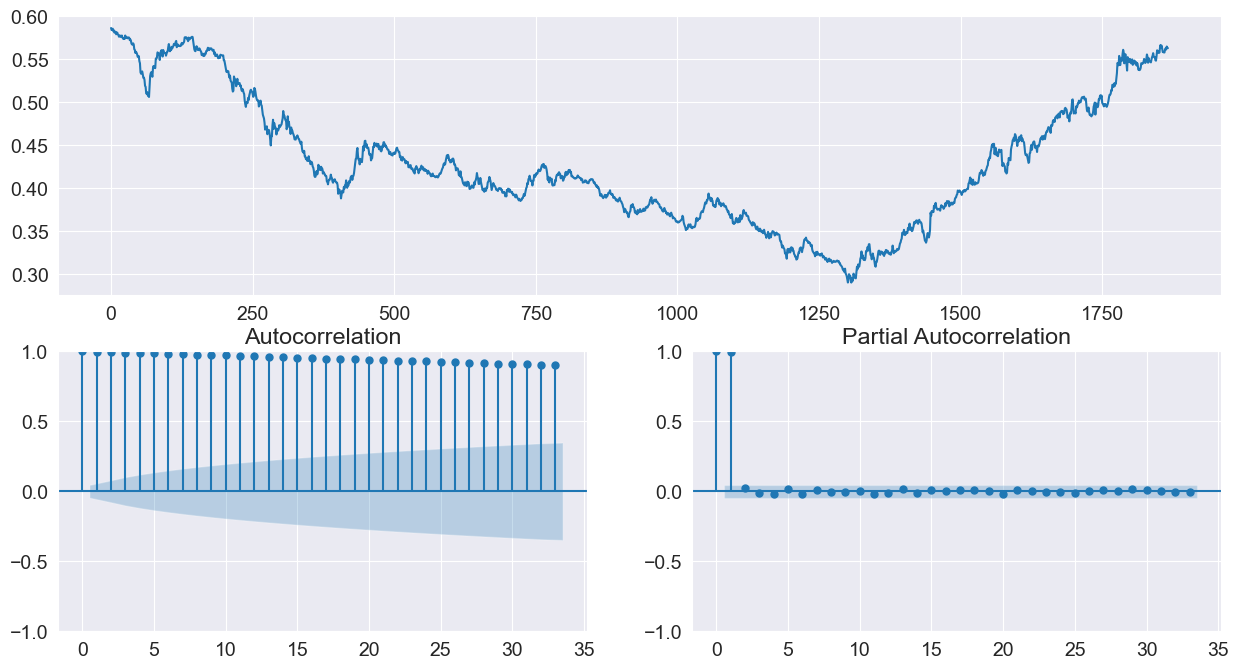

In [5]:
corr_plot(df.DM)
# финансовые ряды почти всегда не стационарны
# наверняка непостоянная дисперсия

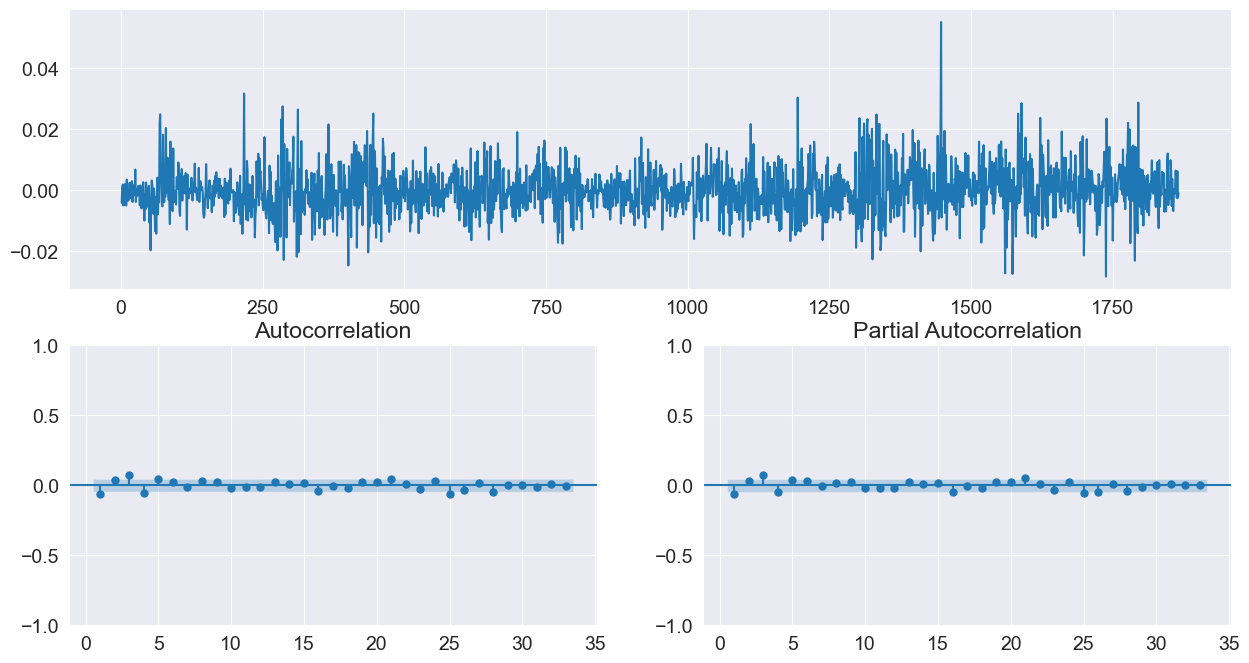

In [6]:
corr_plot(df.DDM[1:], zero=False)

### Как определить волатильность: остатки модели

In [7]:
m = ARIMA(df.DDM, order=(0, 0, 0)).fit()
print(m.summary())

                               SARIMAX Results                                
Dep. Variable:                    DDM   No. Observations:                 1867
Model:                          ARIMA   Log Likelihood                6417.141
Date:                Sat, 23 Dec 2023   AIC                         -12830.283
Time:                        14:11:23   BIC                         -12819.219
Sample:                             0   HQIC                        -12826.206
                               - 1867                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.676e-05      0.000     -0.145      0.885      -0.000       0.000
sigma2      6.032e-05   1.39e-06     43.361      0.000    5.76e-05     6.3e-05
Ljung-Box (L1) (Q):                   6.73   Jarque-

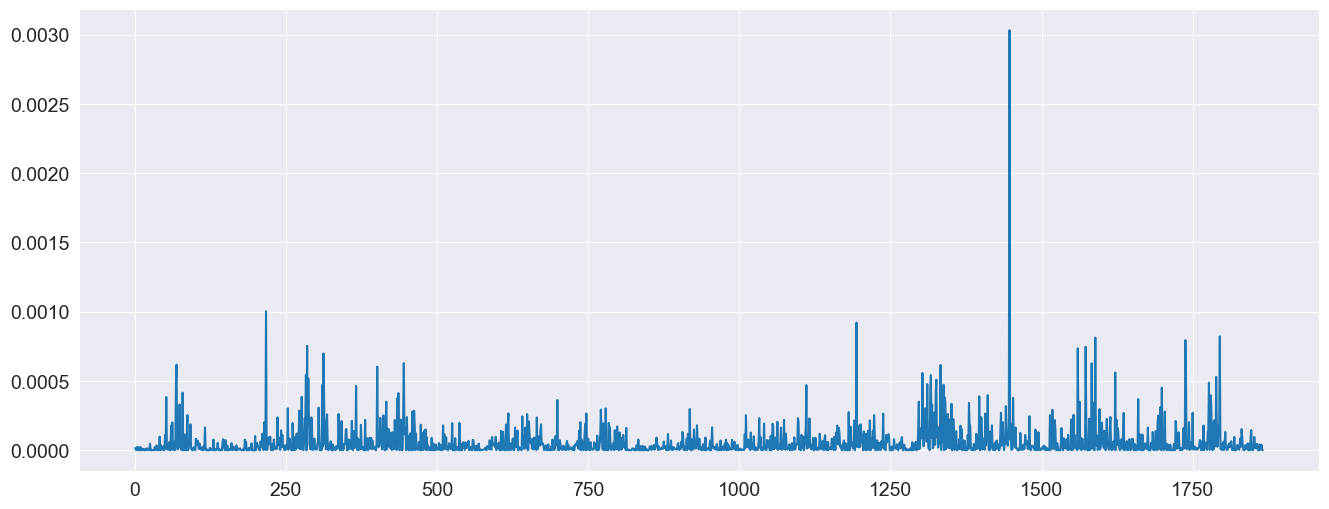

In [8]:
(m.resid**2).plot();

### ARCH(1)

$ y_t = \varepsilon_t $

$ \sigma_t = \nu_t \cdot \varepsilon_t $

$ \sigma_t^2 = \omega + \alpha_1 \cdot \varepsilon_{t-1}^2 $

In [11]:
arch_model(
    y=df.DDM.dropna() * 100, 
    mean='Zero', vol='ARCH', 
    p=1
).fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 21653460.916798472
Iteration:      2,   Func. Count:      9,   Neg. LLF: 2587.371039895222
Iteration:      3,   Func. Count:     15,   Neg. LLF: 2152.975747621693
Iteration:      4,   Func. Count:     17,   Neg. LLF: 2152.975747621437
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2152.975747621693
            Iterations: 4
            Function evaluations: 17
            Gradient evaluations: 4


                        Zero Mean - ARCH Model Results                        
Dep. Variable:                    DDM   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -2152.98
Distribution:                  Normal   AIC:                           4309.95
Method:            Maximum Likelihood   BIC:                           4321.01
                                        No. Observations:                 1866
Date:                Sat, Dec 23 2023   Df Residuals:                     1866
Time:                        14:13:01   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5098  2.783e-02     18.320  5.712e-75   [  0.45

### ARCH(1) с константой

$ y_t = \mu + \varepsilon_t $

$ \sigma_t = \nu_t \cdot \varepsilon_t $

$ \sigma_t^2 = \omega + \alpha_1 \cdot \varepsilon_{t-1}^2 $

In [12]:
arch_model(
    y=df.DDM.dropna()*100, 
    mean='Constant', vol='ARCH', 
    p=1 # p : int, optional
        #     Lag order of the symmetric innovation
).fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12180.12553673586
Iteration:      2,   Func. Count:     13,   Neg. LLF: 613771.3140197359
Iteration:      3,   Func. Count:     19,   Neg. LLF: 2586.656463160447
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2152.765242353861
Iteration:      5,   Func. Count:     29,   Neg. LLF: 2152.765242353887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2152.765242353861
            Iterations: 5
            Function evaluations: 29
            Gradient evaluations: 5


                      Constant Mean - ARCH Model Results                      
Dep. Variable:                    DDM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2152.77
Distribution:                  Normal   AIC:                           4311.53
Method:            Maximum Likelihood   BIC:                           4328.13
                                        No. Observations:                 1866
Date:                Sat, Dec 23 2023   Df Residuals:                     1865
Time:                        14:14:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0112  1.735e-02     -0.644      0.519 

### AR(1)-GARCH(1, 1)

<sub>Процесс для ряда - Процесс для волатильности</sub>

$ y_t = \mu + a \cdot y_{t-1} + \varepsilon_t $

$ \sigma_t = \nu_t \cdot \varepsilon_t $

$ \sigma_t^2 = \omega + \alpha_1 \cdot \varepsilon_{t-1}^2 + \beta_1 \cdot \sigma_{t-1}^2 $

In [13]:
model_garch = arch_model(
    y=df.DDM.dropna() * 100, 
    mean='AR', lags=1, vol='GARCH', # ARX = AR + Exog
    p=1, q=1
).fit(update_freq=0)
# p : int, optional
#     Lag order of the symmetric innovation
# o : int, optional
#     Lag order of the asymmetric innovation
# q : int, optional
#     Lag order of lagged volatility or equivalent
print(model_garch.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2058.239281049037
            Iterations: 12
            Function evaluations: 91
            Gradient evaluations: 12
                           AR - GARCH Model Results                           
Dep. Variable:                    DDM   R-squared:                       0.003
Mean Model:                        AR   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -2058.24
Distribution:                  Normal   AIC:                           4126.48
Method:            Maximum Likelihood   BIC:                           4154.13
                                        No. Observations:                 1865
Date:                Sat, Dec 23 2023   Df Residuals:                     1863
Time:                        14:17:14   Df Model:                            2
                                  Mean Model                                 
  

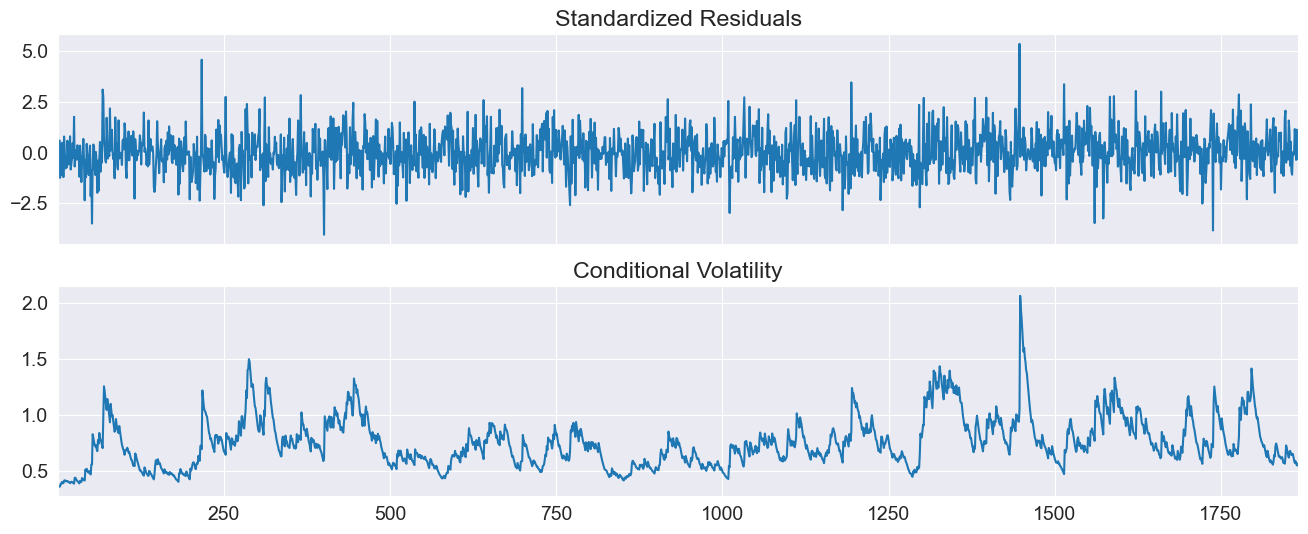

In [14]:
model_garch.plot();
# standardized residuals -> mu
# критерий хорошести Garch -> mu = 0, sigma = 1
# conditional volatility -> sigma?

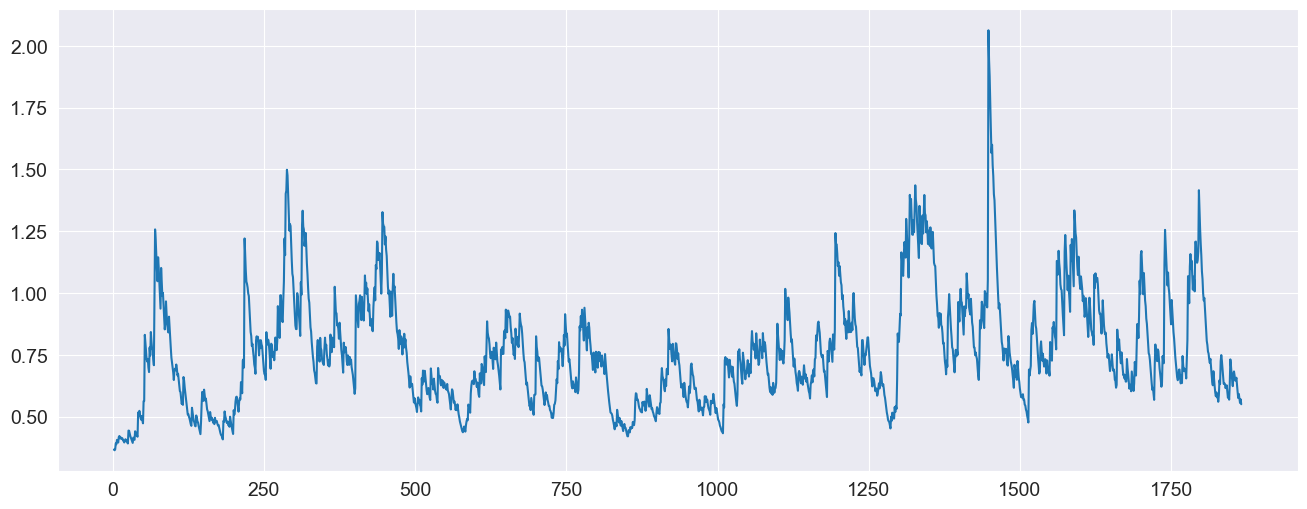

In [15]:
plt.plot(model_garch.conditional_volatility);

Посмотрим на стандартизированные ошибки $ \nu_t $. В хорошей модели они - белый шум с мат. ожиданием 0 и дисперсией 1

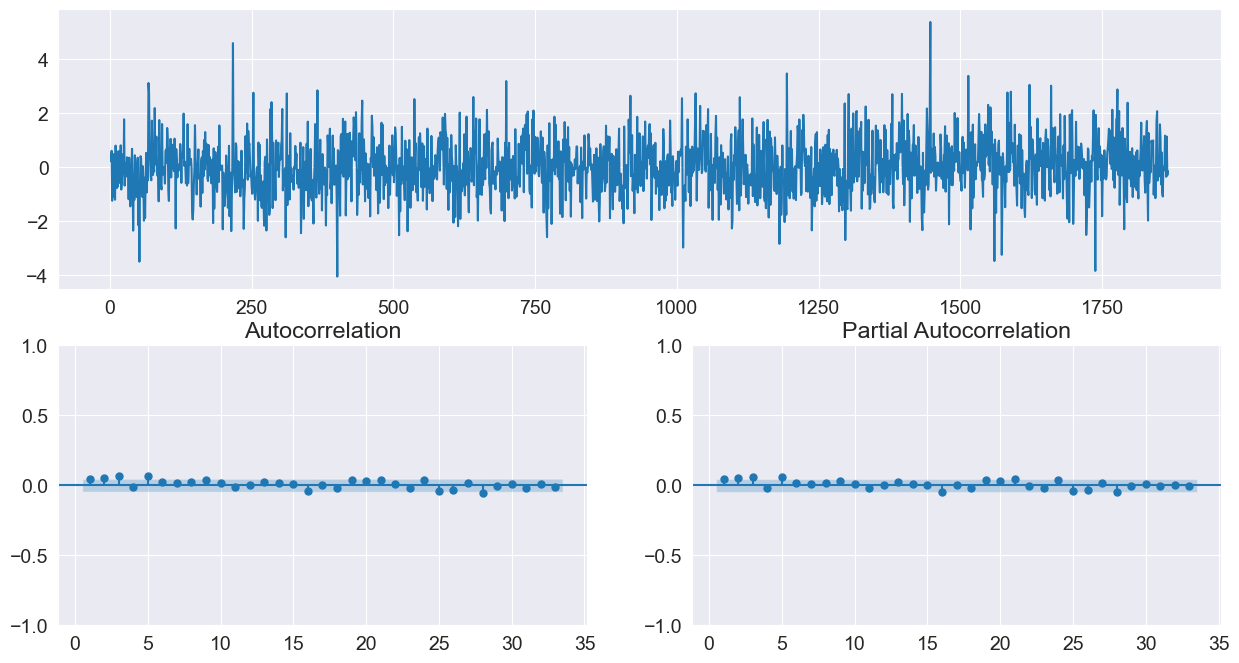

In [16]:
corr_plot(
    model_garch.std_resid.dropna(), zero=False
) # стандартизированные ошибки \nu_t

In [17]:
model_garch.std_resid.mean(), model_garch.std_resid.std()

(0.009882663695711343, 0.999471973060961)

In [18]:
acorr_ljungbox(
    model_garch.std_resid[1:], model_df=2
) # отвергаем гипотезу об отсутствии автокорреляции => надо поменять параметры модели

,lb_stat,lb_pvalue
1,3.258280,NaN
2,8.978945,NaN
3,16.587140,0.000046
4,16.789795,0.000226
5,24.533169,0.000019
6,25.515514,0.000040
7,25.861383,0.000095
8,26.882544,0.000152
9,29.213042,0.000132
10,29.619541,0.000247


### GJR-GARCH(1, 1)

$ y_t = \mu + \varepsilon_t $

$ \sigma_t = \nu_t \cdot \varepsilon_t $

$ \sigma_t^2 = \omega + \alpha_1 \varepsilon_{t-1}^2 + \gamma_1 \varepsilon_{t-1}^2 I_{[\varepsilon_{t-1}<0]} + \beta_1 \sigma_{t-1} $

In [19]:
gjr_garch = arch_model(
    y=df.DDM.dropna() * 100, 
    mean='Constant', vol='GARCH', 
    p=1, o=1, q=1
).fit(update_freq=0)
# GJR -> несимметричный garch
# o - количество лагов с индикаторной переменной
print(gjr_garch.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2061.9410360466554
            Iterations: 13
            Function evaluations: 95
            Gradient evaluations: 13
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                    DDM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2061.94
Distribution:                  Normal   AIC:                           4133.88
Method:            Maximum Likelihood   BIC:                           4161.54
                                        No. Observations:                 1866
Date:                Sat, Dec 23 2023   Df Residuals:                     1865
Time:                        14:26:26   Df Model:                            1
                                  Mean Model                                 
 

In [20]:
acorr_ljungbox(gjr_garch.std_resid[1:]) # только на первом лаге остатки - белый шум
# вопрос с автокорреляцией остатков не решился => отвергаем модель

,lb_stat,lb_pvalue
1,2.040118,0.153198
2,7.342648,0.025443
3,15.347520,0.001543
4,16.255945,0.002694
5,23.953545,0.000222
6,24.533901,0.000416
7,24.765821,0.000835
8,25.524944,0.001266
9,27.443206,0.001181
10,27.882749,0.001885


### TARCH

$ y_t = \mu + \varepsilon_t $

$ \sigma_t = \nu_t \cdot \varepsilon_t $

$ \sigma_t = \omega + \alpha_1 \cdot |\varepsilon_{t-1}| + \gamma_1 |\varepsilon_{t-1}| I_{[\varepsilon_{t-1}<0]} + \beta_1 \cdot |\sigma_{t-1}| $

In [21]:
tarch = arch_model(
    y=df.DDM.dropna() * 100, 
    mean='Constant', vol='GARCH', 
    p=1, o=1, q=1, power=1.0 
    # power : float, optional
    #     Power to use with GARCH and related models
).fit(update_freq=0)
# tarch не переобучается на скачках
print(tarch.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2061.162525044846
            Iterations: 15
            Function evaluations: 110
            Gradient evaluations: 15
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                    DDM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -2061.16
Distribution:                  Normal   AIC:                           4132.33
Method:            Maximum Likelihood   BIC:                           4159.98
                                        No. Observations:                 1866
Date:                Sat, Dec 23 2023   Df Residuals:                     1865
Time:                        14:30:23   Df Model:                            1
                                  Mean Model                                 
 

In [22]:
acorr_ljungbox(tarch.std_resid[1:]) # не белый шум

,lb_stat,lb_pvalue
1,2.188988,0.139001
2,7.255317,0.026578
3,15.743717,0.001280
4,16.701111,0.002209
5,24.664641,0.000162
6,25.346068,0.000295
7,25.737099,0.000561
8,26.398939,0.000897
9,28.289746,0.000853
10,28.704200,0.001391


### GJR-GARCH with Student-T Errors

$ y_t = \mu + \varepsilon_t $

$ \sigma_t = \nu_t \cdot \varepsilon_t, \nu_t \sim StudentT(\nu) $

$ \sigma_t^2 = \omega + \alpha_1 \varepsilon_{t-1}^2 + \gamma_1 \varepsilon_{t-1}^2 I_{[\varepsilon_{t-1}<0]} + \beta_1 \sigma_{t-1} $

In [23]:
gjr_garch_t = arch_model(
    y=df.DDM.dropna() * 100, 
    mean='Constant', vol='GARCH', 
    p=1, o=1, q=1, dist='StudentsT'
).fit(update_freq=0)
# nu -- параметр степеней свободы Стьюдента
# юзаем в качестве попытки устранения автокорреляции остатков
print(gjr_garch_t.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2041.8501088321998
            Iterations: 12
            Function evaluations: 100
            Gradient evaluations: 12
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                          DDM   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2041.85
Distribution:      Standardized Student's t   AIC:                           4095.70
Method:                  Maximum Likelihood   BIC:                           4128.89
                                              No. Observations:                 1866
Date:                      Sat, Dec 23 2023   Df Residuals:                     1865
Time:                              14:32:17   Df Model:                            1
                        

In [24]:
acorr_ljungbox(gjr_garch_t.std_resid[1:])

,lb_stat,lb_pvalue
1,2.142059,0.143309
2,7.321251,0.025716
3,15.169365,0.001677
4,16.131466,0.002848
5,23.715258,0.000246
6,24.308011,0.000458
7,24.535866,0.000917
8,25.287584,0.001389
9,27.164527,0.001314
10,27.583888,0.002104


### EGARCH(1, 1)

$ y_t = \mu + \varepsilon_t $

$ e_t  = \varepsilon_t / \sigma_t $

$ \ln\sigma_t^2 = \omega + \alpha_1 \left|e_{t-1} - \sqrt{2/\pi}\right| + \gamma_1 e_{t-1} + \beta_1 \ln\sigma_{t-1} $

In [25]:
egarch = arch_model(
    y=df.DDM.dropna() * 100, 
    mean='Constant', vol='EGARCH', 
    p=1, o=1, q=1
).fit(update_freq=0)
# когда ничего не помогает
print(egarch.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2060.212277035145
            Iterations: 10
            Function evaluations: 78
            Gradient evaluations: 10
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                    DDM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2060.21
Distribution:                  Normal   AIC:                           4130.42
Method:            Maximum Likelihood   BIC:                           4158.08
                                        No. Observations:                 1866
Date:                Sat, Dec 23 2023   Df Residuals:                     1865
Time:                        14:34:13   Df Model:                            1
                                  Mean Model                                 
  

### FIGARCH (fractionally integrated)

Подробнее: https://stat.tugraz.at/AJS/ausg123/123Tayefi.pdf

$ y_t = \mu + \varepsilon_t $

$ \sigma_t = \nu_t \cdot \varepsilon_t $

$ \sigma_t^2 = \omega + \left(1 - \beta L - \phi L (1-L)^d\right) \varepsilon_{t}^2 + \beta_1 \sigma_{t-1}^2 $

In [26]:
figarch = arch_model(
    y=df.DDM.dropna() * 100, 
    mean='Constant', vol='FIGARCH', 
    p=1, q=1
).fit(update_freq=0)
print(figarch.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2061.967585662772
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 9
                    Constant Mean - FIGARCH Model Results                     
Dep. Variable:                    DDM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:               -2061.97
Distribution:                  Normal   AIC:                           4133.94
Method:            Maximum Likelihood   BIC:                           4161.59
                                        No. Observations:                 1866
Date:                Sat, Dec 23 2023   Df Residuals:                     1865
Time:                        14:35:31   Df Model:                            1
                                  Mean Model                                 
    